This notebook aims to create a preprocessor to pre-process and transform features and then save it as a pickle file

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import pickle

In [3]:
df=pd.read_csv(r'../artifacts/UCI_Credit_Card.csv')
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

# Creating Custom Estimator for dropping Id column

In [4]:
class IdDropper(BaseEstimator,TransformerMixin):
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return X.drop('ID',axis=1)

In [5]:
id=IdDropper()
X=id.fit_transform(df)  
X.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

# Creating Custom Estimators for Removing outliers

In [6]:
def cap_upper(df,feature,limit):
    
    percentile_limit=df[feature].quantile(limit)
    df.loc[df[feature]>=percentile_limit,feature]=percentile_limit
    return df[feature]

In [7]:
class RemoveOutliers(BaseEstimator,TransformerMixin):
    
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        
        # Limit _Balance capping at 95%
        X['LIMIT_BAL']=cap_upper(X,'LIMIT_BAL',0.95)
        
        # Capping at 90%
        for col in ['BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']:
            X[col]=cap_upper(X,col,0.90)
        
        for col in ['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']:
            X[col]=cap_upper(X,col,0.90)
        
        return X

In [8]:
rm_outlier=RemoveOutliers()
X=rm_outlier.fit_transform(df)

# works fine

<AxesSubplot:xlabel='LIMIT_BAL'>

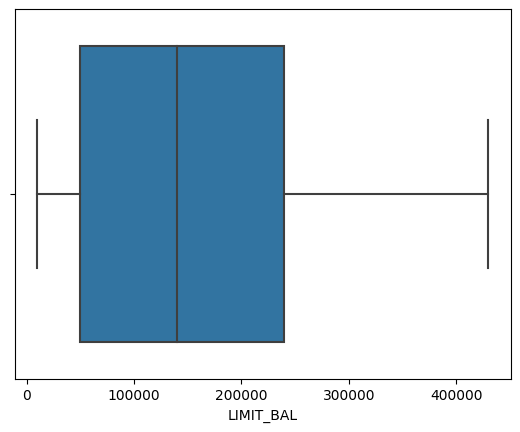

In [9]:
sns.boxplot(data=X,x='LIMIT_BAL')

<AxesSubplot:xlabel='BILL_AMT1'>

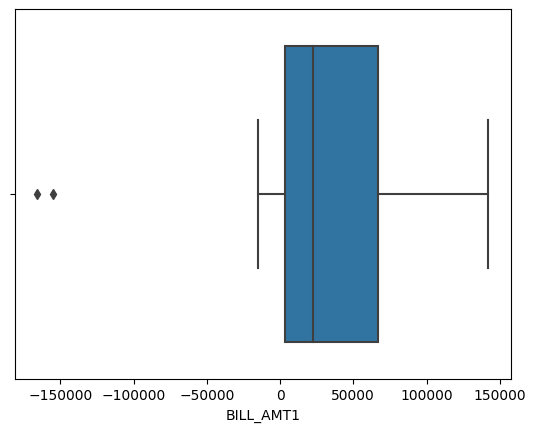

In [10]:
sns.boxplot(data=X,x='BILL_AMT1')

# Creating Custom Estimator For feature Encoding

In [11]:
class FeatureEncoder(BaseEstimator,TransformerMixin):
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        
        # encoding sex
        if X['SEX'].dtype!='int64':
            X['SEX']=X['SEX'].map({'male':1,'female':2})
            
        # encoding education
        if X['EDUCATION'].dtype!='int64':
            X['EDUCATION']=X['EDUCATION'].map({'graduate school':1,'university':2,'high school':3,'others':4})
        # if education is already encoded then handling erroneous values
        X['EDUCATION']=X['EDUCATION'].apply(lambda x:str(x)).str.replace(r'[0456]','4')
        X['EDUCATION']=X['EDUCATION'].astype('int64')
        
        # encoding marriage
        if X['MARRIAGE'].dtype!='int64':
            X['MARRIAGE']=X['MARRIAGE'].map({'married':1,'single':2,'others':3})
        # if marriage is already encoded then handling erroneous values
        X['MARRIAGE']=X['MARRIAGE'].apply(lambda x:str(x)).str.replace(r'[30]',r'3')
        X['MARRIAGE']=X['MARRIAGE'].astype('int64')
        
        # repayment status
        for col in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            X[col]=X[col].apply(lambda x: x if x>0 else 0) # if x is negative or zero then it's paid on time or in advance

        return X

In [12]:
fe=FeatureEncoder()
X=fe.fit_transform(X)



In [13]:
X['PAY_0'].value_counts(normalize=True)

0    0.772733
1    0.122933
2    0.088900
3    0.010733
4    0.002533
5    0.000867
8    0.000633
6    0.000367
7    0.000300
Name: PAY_0, dtype: float64

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

# Creating a custom estimator for Feature Scaling


In [15]:
X.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [16]:
class FeatureScaling(BaseEstimator,TransformerMixin):
    
    
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        columns=['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3','BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2','PAY_AMT3','PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6' ]
        normalizer=MinMaxScaler()
        for col in columns:
            X[col]=normalizer.fit_transform(X[[col]])
        
        return X

In [17]:
fs=FeatureScaling()
X=fs.fit_transform(X)

# Let's now create the pre-processor object

In [18]:
preprocessor=Pipeline(
    steps=[
        ('id_dropper',IdDropper()),
        ('rm_outlier',RemoveOutliers()),
        ('fe',FeatureEncoder()),
        ('fs',FeatureScaling())
    ]
)

In [25]:
df=pd.read_csv(r'../artifacts/UCI_Credit_Card.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [26]:
clean_df=preprocessor.fit_transform(df.drop(['default.payment.next.month'],axis=1))

In [29]:
clean_df=pd.concat([clean_df,df['default.payment.next.month']],axis=1)

In [30]:
clean_df.to_csv('../artifacts/Clean_df.csv',index=False)

In [21]:
# Let's save the pre processor

with open('../artifacts/preprocessor.pkl','wb') as f:
    pickle.dump(preprocessor,f)

In [22]:
# Let's save the pre processor

with open('../artifacts/preprocessor.pkl','rb') as f:
    obj=pickle.load(f)